this script is to generate basic statistical summary for MinION that contains barcodes. It can be also adapted to generate summary for basecalled data with no barcodes. The code is adapted from Gamran Green.

In [1]:
import os
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import numpy as np
import argparse
import tarfile
from itertools import product

In [2]:
#lets define the base folder
BASEDIR = '/home/yiheng/data/20180522_FAH54299'
#BASEDIR = args.BASEDIR
#this will become the only flag of argparse
good_barcodes = ['barcode01', 'barcode02', 'barcode03', 'barcode04', 'barcode05', 'barcode06', 'barcode07', 'barcode08', 'barcode09', 'barcode10', 'barcode11', 'barcode12']

In [3]:
# define the columns that you want to pick up from sequencing summary file.
# Here is the columns I chose for plotting out data, enough information for me so I did not pick others.
seq_df_headers = ['read_id','passes_filtering', 'sequence_length_template', 'mean_qscore_template',\
                  'barcode_arrangement']

In [4]:
#now check again if the basecalled data is there
BASECALLFOLDER = os.path.join(os.path.abspath(BASEDIR),'basecalled_data' )
if not os.path.exists(BASECALLFOLDER):
    print('No basecalled data in %s. Exit!' % BASEDIR)
    #exit()

In [5]:
SCRIPT_FOLDER = os.path.join(os.path.abspath(BASEDIR), 'scripts')
WORKSPACE = os.path.join(os.path.abspath(BASEDIR), 'workspace')
TRACKING = os.path.join(os.path.abspath(BASEDIR), 'tracking')
ANALYSIS = os.path.join(os.path.abspath(BASEDIR), 'analysis')
if not os.path.exists(SCRIPT_FOLDER):
    os.mkdir(SCRIPT_FOLDER)
if not os.path.exists(WORKSPACE):
    os.mkdir(WORKSPACE)
if not os.path.exists(TRACKING):
    os.mkdir(TRACKING)
if not os.path.exists(ANALYSIS):
    os.mkdir(ANALYSIS)

In [6]:
if  len([os.path.join(BASECALLFOLDER, x) for x in os.listdir(BASECALLFOLDER) if x.endswith('tar.gz')]) == 1:
    tar_file = [os.path.join(BASECALLFOLDER, x) for x in os.listdir(BASECALLFOLDER) if x.endswith('tar.gz')][0]
    runid = tar_file.split('/')[-1].split('.')[0]
    #now untar the tar gz file
    os.chdir(BASECALLFOLDER)
    unzip_command = 'tar -xvf %s' % (tar_file)
    print(unzip_command)
    unzip_command_stderr = subprocess.check_output(unzip_command, shell=True, stderr=subprocess.STDOUT)
else:
    print('None or mulitiple tar files')

tar -xvf /home/yiheng/data/20180522_FAH54299/basecalled_data/20180522_FAH54299_albacore231.tar.gz


In [7]:
os.listdir(BASECALLFOLDER)

['20180522_FAH54299_albacore231.tar.gz', '20180522_FAH54299_albacore231']

In [8]:
#now we should have generated the folder with the basecallded data
BASECALLED_DATA_FOLDER = os.path.join(BASECALLFOLDER, tar_file.split('.')[0])
if not os.path.exists(BASECALLED_DATA_FOLDER):
    print("Something with the unzipping of the basecalled data went wrong.")


In [9]:
#check the contents in the zipped folder
content = ['workspace', 'configuration.cfg', 'sequencing_summary.txt', 'pipeline.log']
if not set(os.listdir(BASECALLED_DATA_FOLDER)) == set(content):
    print("Something with the unzipping of the basecalled data might be wrong.")

BASECALLED_DATA_WORKSPACE = os.path.join(BASECALLED_DATA_FOLDER, 'workspace')

Something with the unzipping of the basecalled data might be wrong.


In [10]:
#now get the headers sequencing_summary file
base_called_folder = os.path.join(BASEDIR, 'basecalled_data')

# here added a function to check the tar.gz file and its corresponding unzipped folder in the basecalled_data folder.  
# If it is not unzipped, unzip it.
for thing in os.listdir(base_called_folder):
    judge_list = [os.path.isdir(os.path.join(base_called_folder, thing))]

if any(x == True for x in judge_list):
    seq_sum_file = os.path.join(base_called_folder, thing, 'sequencing_summary.txt')
    if not os.path.exists(seq_sum_file):
        print('No sequencing summary file from basecalled folder. Please go check')
        
    print("now getting the headers from %s" % seq_sum_file)
    seq_df = pd.read_csv(seq_sum_file, sep='\t')
    #capture the thing as the prefix of the fastq/fasta files in the barcode folders
    prefix = thing
    #might be a better way to only read in the wanted columns. Not subsetting afterwards.
    #please go check
    seq_df = seq_df.loc[:, seq_df_headers].copy()
    
elif all(x == False for x in judge_list):
        
    zipped_basecalled_file = os.path.join(base_called_folder, thing)
    if zipped_basecalled_file.endswith('tar.gz'):
        print("now unzipping file %s." % zipped_basecalled_file)
        tar = tarfile.open(zipped_basecalled_file)
        tar.extractall(base_called_folder.split(".")[0])
        tar.close()
    else:
        print("there is something strange in the basecalled folder, please check.")
else:
        print("there is something strange in the basecalled folder, please check.")

now getting the headers from /home/yiheng/data/20180522_FAH54299/basecalled_data/20180522_FAH54299_albacore231/sequencing_summary.txt


/home/yiheng/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,16,17,18,20,22,23,24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
# now try to replace misclassified or unclassified barcodes into barcode00
passed_seq_df = seq_df[seq_df.passes_filtering == True]
all_barcodes = set(seq_df.barcode_arrangement)
wrong_barcodes = sorted(list(all_barcodes - set(good_barcodes)))

for x in wrong_barcodes:
    seq_df.barcode_arrangement.replace(to_replace=x, value='unclassified', inplace=True)


In [12]:
#passed_seq_df.reset_index(drop = True)

/home/yiheng/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


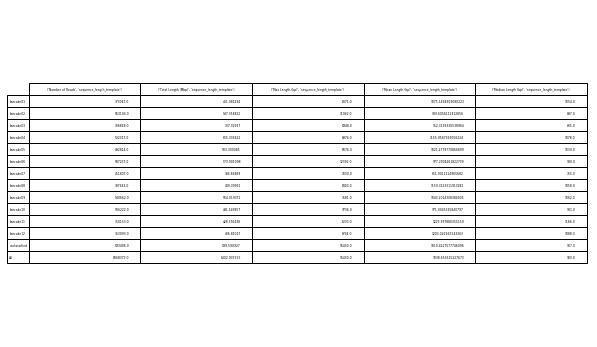

In [13]:
#passed_seq_df.set_index(['barcode_arrangement', 'sequence_length_template']).unstack('barcode_arrangement')

#change datatype of the value column to be numeric
passed_seq_df.sequence_length_template = passed_seq_df.sequence_length_template.astype(float)

passed_seq_df_pivot = passed_seq_df.pivot_table(values='sequence_length_template', 
                                                index='barcode_arrangement', 
                                                aggfunc=[len, np.sum, np.max, np.mean, np.median],
                                                #aggfunc='first',
                                                fill_value=0,
                                                margins=True)
#change display options  of floats
pd.options.display.float_format = '{:.0f}'.format

passed_seq_df_pivot.index.name = None
for clmns in ['len', 'amax', 'median']:
    passed_seq_df_pivot[clmns] = passed_seq_df_pivot[clmns].astype(int)
passed_seq_df_pivot['sum'] = passed_seq_df_pivot['sum']/1000000

passed_seq_df_pivot_formal = passed_seq_df_pivot.copy() #titles have whitespace, make fancier
passed_seq_df_pivot_formal.rename(columns={'len': 'Number of Reads', 
                                    'sum': 'Total Length (Mbp)',
                                    'amax': 'Max Length (bp)',
                                    'mean': 'Mean Length (bp)',
                                    'median': 'Median Length (bp)'}, inplace=True)
# Saves the table summary in the /analysis/ subdirectory
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1, 1, 1, frame_on=False)
ax.xaxis.set_visible(False)  # hide the x axis
ax.yaxis.set_visible(False)  # hide the y axis

table(ax, passed_seq_df_pivot_formal, loc='center')

plt.savefig(os.path.join(ANALYSIS, "passed_basecalled_reads_summary.png"), dpi=600)
plt.show()

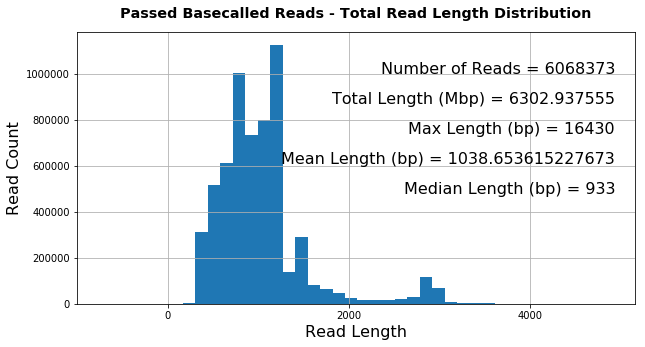

In [14]:
### CONSTRUCT HISTOGRAMS CHARTING READ DISTRIBUTION, BASED FROM THE DATAFRAME ###
bc_list = passed_seq_df_pivot.index
bc_list = list(bc_list)
bc_list.remove('All')
# Function that generates a random colour
def random_color(x=1):
    r = lambda: random.randint(0,255)
    return ('#%02X%02X%02X' % (r(),r(),r()))


#Generates a histogram showing the total read length distribution for all basecalled reads
plt.figure(figsize=(10,5))
passed_seq_df[passed_seq_df.sequence_length_template < passed_seq_df.sequence_length_template.mean()*4]['sequence_length_template'].hist(bins=30)

plt.title('Passed Basecalled Reads - Total Read Length Distribution', y=1.03, fontsize='x-large', fontweight='bold')

plt.xlabel('Read Length', fontsize=16)
plt.xticks(np.arange(0, passed_seq_df.sequence_length_template.mean()*4 + 1, 2000))
plt.xlim([-1000, passed_seq_df.sequence_length_template.mean()*4 + 1000])

plt.ylabel('Read Count', fontsize=16)


for idx, clmn_name in enumerate(list(passed_seq_df_pivot_formal.columns)):
    plt.annotate(clmn_name[0] + ' = ' + str(passed_seq_df_pivot_formal[clmn_name]['All']), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')
    
plt.savefig(os.path.join(ANALYSIS, "passed_basecalled_reads_distribution.png"), dpi=600)
plt.show()

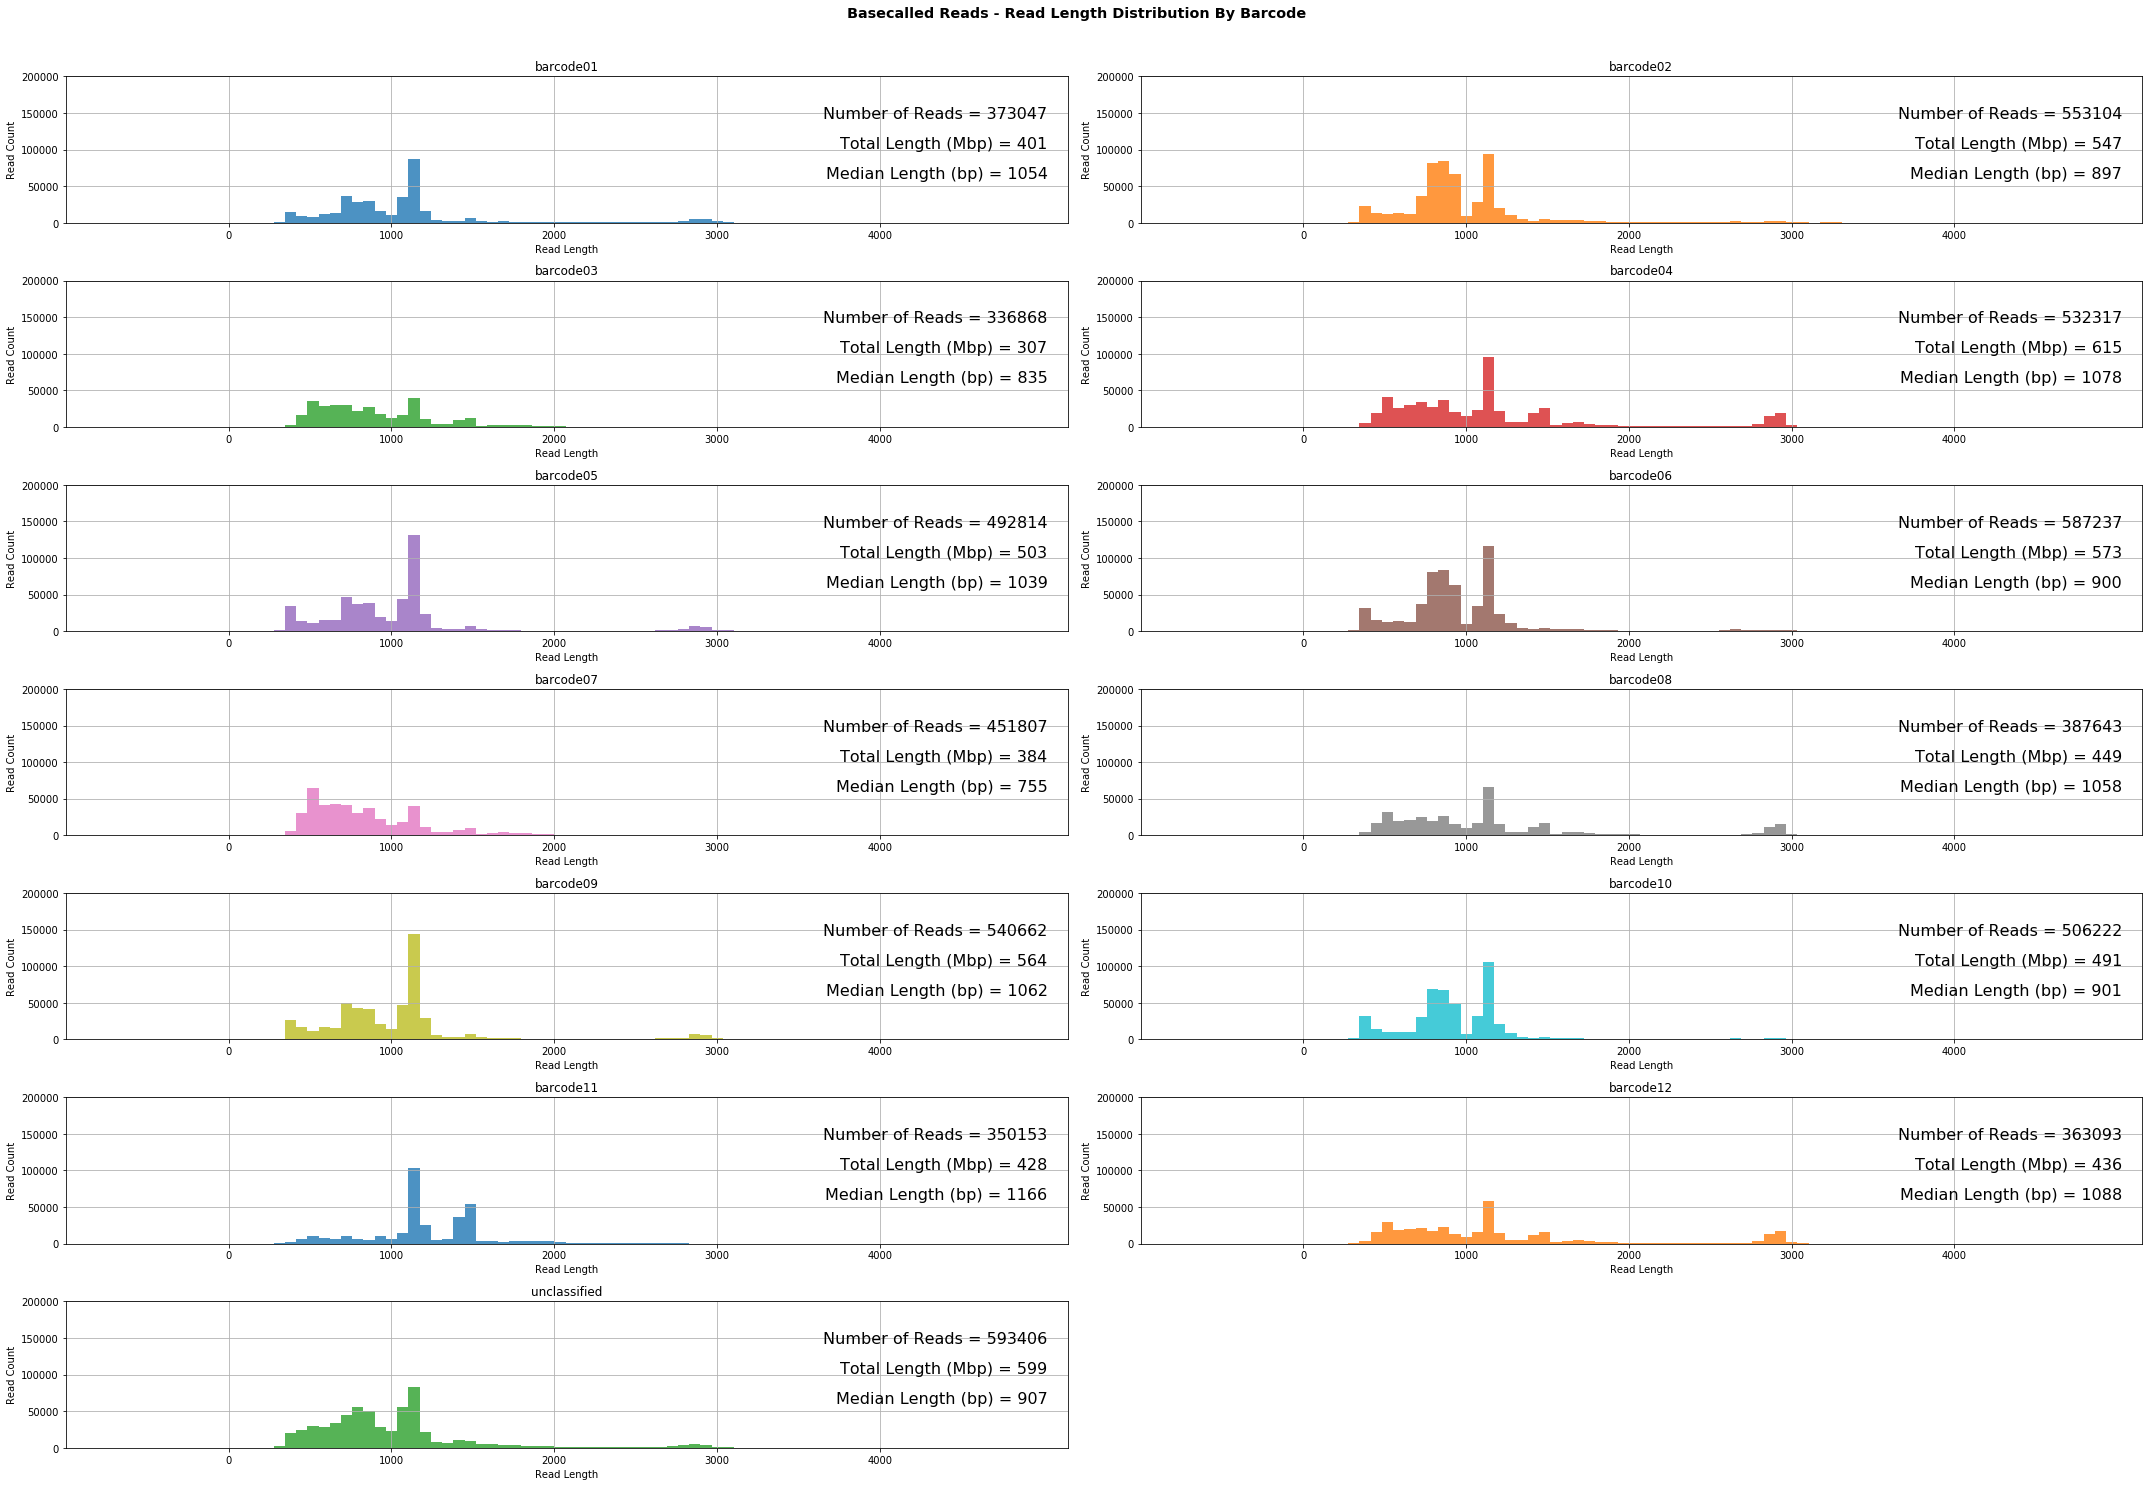

In [15]:
#do something like subset_df[subset_df.Length < subset_df.Length.mean()*4]
subset_df = passed_seq_df[passed_seq_df.sequence_length_template < passed_seq_df.sequence_length_template.mean()*4]

#set colormap
# colormap = plt.cm.tab10.colors 

def get_color(x):
    x = x%10
    return ('#%02X%02X%02X' % (int(plt.cm.tab10.colors[x][0]*255),int(plt.cm.tab10.colors[x][1]*255),int(plt.cm.tab10.colors[x][2]*255)))

#Generates a histogram showing the total read length distribution for all basecalled reads per barcode
basecalled_barcodes = list(subset_df['barcode_arrangement'].unique())

if len(list(subset_df['barcode_arrangement'].unique())) % 2 == 0:
    no_of_subplots = len(basecalled_barcodes)
else:
    no_of_subplots = len(basecalled_barcodes) + 1

#Always 2 columns, bc-count/2 rows 
no_of_subplots_pair = [int(no_of_subplots/2), 2]

#Produce pairs of indices correlating to the coordinates of the subplots
subplot_coordinates = list(product(range(no_of_subplots_pair[0]), range(no_of_subplots_pair[1])))
subplot_coordinates_list = [list(l) for l in subplot_coordinates]
subplot_coordinates_list_rows = [i[0] for i in subplot_coordinates_list]
subplot_coordinates_list_columns = [i[1] for i in subplot_coordinates_list]

fig, ax = plt.subplots(no_of_subplots_pair[0], no_of_subplots_pair[1], figsize=(30,20))

xmax = int(subset_df.sequence_length_template.max())

max_count_list = []
for bcs in list(subset_df['barcode_arrangement'].unique()):
    max_count_list.append(np.histogram(subset_df.loc[subset_df['barcode_arrangement'] == bcs] ['sequence_length_template'], 60)[0].max())
max_count_list.sort()
max_count_list_max = max_count_list[-1]
max_count_list_max_digits = len(str(max_count_list_max))
exact_ylim = (int(max_count_list_max / 10**(max_count_list_max_digits-1))+1)*(10**(max_count_list_max_digits-1))

def applyGroupHistograms(ax_ind1, ax_ind2, bcs):
    ax[ax_ind1, ax_ind2].hist(subset_df.groupby('barcode_arrangement')['sequence_length_template'].get_group(bcs), 
                              bins=range(0, xmax, int(xmax/60)),
                              color=get_color(ax_ind1 * 2 + ax_ind2),
                              #color=random_color(), 
                              alpha=0.8)
    ax[ax_ind1, ax_ind2].set_title(bcs)
    ax[ax_ind1, ax_ind2].set_xlabel('Read Length')
    ax[ax_ind1, ax_ind2].set_ylabel('Read Count');
    ax[ax_ind1, ax_ind2].set_xlim([-1000, subset_df['sequence_length_template'].max() + 1000])
    ax[ax_ind1, ax_ind2].set_xticks(np.arange(0, xmax + 1, 1000))
    ax[ax_ind1, ax_ind2].set_ylim(0, exact_ylim)
    ax[ax_ind1, ax_ind2].grid(True, which='Major')
 #this adds the text to the    
    for idx, clmn_name in enumerate(['Number of Reads', 'Total Length (Mbp)', 'Median Length (bp)']):
        ax[ax_ind1, ax_ind2].annotate(clmn_name + ' = ' + str(int(passed_seq_df_pivot_formal.loc[bcs, clmn_name])), 
                 xy=(1, 1), 
                 xycoords='axes fraction', 
                 fontsize=16, 
                 fontweight='normal',
                 xytext=(-20, -30 - 30*idx), 
                 textcoords='offset points', 
                 ha='right', 
                 va='top')

for ax_ind1, ax_ind2, bcs, in zip(subplot_coordinates_list_rows, subplot_coordinates_list_columns, bc_list):
    applyGroupHistograms(ax_ind1, ax_ind2, bcs)    

if len(list(subset_df['barcode_arrangement'].unique())) != 0:
    plt.delaxes(ax[subplot_coordinates_list_rows[-1], subplot_coordinates_list_columns[-1]])

plt.suptitle('Basecalled Reads - Read Length Distribution By Barcode', 
             y=1.03, 
             fontsize='x-large', 
             fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(ANALYSIS, 'passed_basecalled_read_distribution_bcsort.png'), bbox_inches='tight', dpi=600)    
plt.show()